In [1]:
import glob
import json
import os
import re
from pathlib import Path

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

plt.style.use(["science", "no-latex"])
my_style = {
    "text.usetex": False,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.015,
    "font.size": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 12,
}
plt.rcParams.update(my_style)

# Data Loading

In [2]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]


def get_simple_name(dataset_name):
    dataset_name = dataset_name.replace("mnist", "") if dataset_name not in ("mnist", "fmnist") else dataset_name
    return dataset_name


def read_metrics_csv_files(file_pattern, with_labels=False):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df["Method"] = df["Method"].apply(lambda s: s.split()[0])
        if with_labels:
            df["Method"] = df["Method"].apply(lambda s: s+"-labels")
            
        df["Split"] = "train" if "_train" in file_path else "test"
        # Query existing levels
        current_levels = list(df.index.names)
        df = df.set_index(["Dataset", "N", "Split"])
        # Create MultiIndex columns
        df = df.pivot(columns="Method", values=["NMSE", "PSNR", "SSI"])
        df.rename(columns={"NMSE": "NRMSE", "SSI": "SSIM"}, level=0, inplace=True)

        # Sort column labels
        df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data).sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )

In [3]:
def read_class_csv_files(file_pattern, with_labels=False):    
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file, header=[0, 1], index_col=[0, 1])
        # Query existing levels
        current_levels = list(df.index.names)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df = df.set_index(["Dataset", "N"], append=True)
        df = df.reorder_levels(["Dataset", "N"] + current_levels)
        all_data.append(df)

    df = pd.concat(all_data)
    df.columns.set_names("Method", level=1, inplace=True)
    df.rename(columns={"PCA": "PCA"}, level=1, inplace=True)
    df.rename(columns={"Accuracy": "ACC", "F1-Score": "F1"}, level=0, inplace=True)   
    df = df[["ACC", "F1"]]
    df.index = df.index.set_levels(df.index.levels[3].str.lower(), level="Split")
    df =  df.sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )
    if with_labels:        
        # Rename "POLCA" to "POLCA-labels" in the second level
        # Get the current column levels
        level_0 = df.columns.get_level_values(0)
        level_1 = df.columns.get_level_values(1)        
        # Create new level_1 with 'POLCA' replaced by 'POLCA-labels'
        new_level_1 = ['POLCA-labels' if x == 'POLCA' else "PCA-labels" for x in level_1]
        new_columns = pd.MultiIndex.from_arrays([level_0, new_level_1], names=[None, 'Method'])
        df.columns = new_columns
        # df = df.xs('POLCA\nlabels', axis=1, level=1)
    
        
    return df

In [4]:
def read_loss_interaction_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["losses"] = "$\\frac{" + df["loss1"] + "}{" + df["loss2"] + "}$"
        df = df.drop(["loss1", "loss2"], axis=1)
        # Sort column labels
        # df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data)

## Set experiment directory name

In [5]:
experiment = "experiments_10"
with_labels = False

In [7]:
df_metrics = read_metrics_csv_files(f"output/{experiment}/*/image_metrics_*.csv",with_labels=with_labels)
df_metrics.head(6)

NRMSE             PSNR             SSIM        
Method                  PCA   POLCA      PCA    POLCA     PCA   POLCA
Dataset    N  Split                                                  
sinusoidal 8  test   0.1892  0.1189  20.4884  24.6472  0.8325  0.9275
              train  0.1879  0.1001  20.5280  26.0263  0.8361  0.9492
bent       45 test   0.3345  0.4442  14.6565  12.1061  0.5972  0.0365
              train  0.3111  0.4441  15.3228  12.1118  0.6640  0.0390
mnist      11 test   0.5454  0.3928  15.1314  18.1060  0.5013  0.6898
              train  0.5531  0.3974  15.0848  18.0812  0.4956  0.6870

In [9]:
df_class = read_class_csv_files(f"output/{experiment}/*/classification_metrics_*.csv",with_labels=with_labels)
df_class.head(12)

ACC                  F1          
Method                                     PCA     POLCA       PCA     POLCA
Dataset N  Classifier          Split                                        
mnist   11 Linear SVM          test   0.847400  0.922500  0.846933  0.922317
                               train  0.843867  0.916383  0.843271  0.916169
           Logistic Regression test   0.810300  0.895600  0.809644  0.895460
                               train  0.806867  0.889850  0.806142  0.889651
           Perceptron          test   0.699300  0.824100  0.692989  0.819359
                               train  0.688783  0.812117  0.680193  0.804645
           Ridge Classifier    test   0.716700  0.834000  0.690928  0.829552
                               train  0.703367  0.823350  0.675769  0.817776
fmnist  8  Linear SVM          test   0.749300  0.770000  0.745900  0.766203
                               train  0.755800  0.777867  0.751484  0.773778
           Logistic Regression test   0.731400  0.751600  0.728105  0.748488
                               train  0.738550  0.759383  0.734449  0.754994

In [10]:
df_class_aggregated = df_class[["ACC", "F1"]].groupby(level=["Dataset", "N", "Split"]).mean()
df_class_aggregated.head(6)

ACC                  F1          
Method                PCA     POLCA       PCA     POLCA
Dataset N Split                                        
blood   8 test   0.571763  0.594490  0.555154  0.567856
          train  0.573543  0.605214  0.556239  0.577530
breast  8 test   0.745192  0.741987  0.710066  0.686296
          train  0.743590  0.733516  0.715217  0.681387
chest   8 test   0.487396  0.488042  0.019175  0.023508
          train  0.494463  0.496129  0.019048  0.024627

In [11]:
df_joint = df_metrics.join(df_class_aggregated, how="outer")
df_joint.head(6)

NRMSE             PSNR             SSIM               ACC  \
Method               PCA   POLCA      PCA    POLCA     PCA   POLCA       PCA   
Dataset N  Split                                                               
bent    45 test   0.3345  0.4442  14.6565  12.1061  0.5972  0.0365       NaN   
           train  0.3111  0.4441  15.3228  12.1118  0.6640  0.0390       NaN   
blood   8  test   0.1381  0.1322  19.9512  20.3825  0.5123  0.5369  0.571763   
           train  0.1378  0.1210  19.9714  21.0877  0.5151  0.5704  0.573543   
breast  8  test   0.2566  0.2879  20.4567  21.4966  0.3630  0.4313  0.745192   
           train  0.2567  0.0134  20.6007  49.0335  0.3805  0.9956  0.743590   

                                  F1            
Method               POLCA       PCA     POLCA  
Dataset N  Split                                
bent    45 test        NaN       NaN       NaN  
           train       NaN       NaN       NaN  
blood   8  test   0.594490  0.555154  0.567856  
           train  0.605214  0.556239  0.577530  
breast  8  test   0.741987  0.710066  0.686296  
           train  0.733516  0.715217  0.681387

# Latex Results Table

In [12]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]
# Sort the DataFrame by dataset
df_latex = df_joint.sort_index(
    level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
)
df_latex = df_latex.round(2)


df_latex.head(10)

NRMSE         PSNR         SSIM         ACC          F1  \
Method                PCA POLCA    PCA  POLCA   PCA POLCA   PCA POLCA   PCA   
Dataset    N  Split                                                           
sinusoidal 8  test   0.19  0.12  20.49  24.65  0.83  0.93   NaN   NaN   NaN   
              train  0.19  0.10  20.53  26.03  0.84  0.95   NaN   NaN   NaN   
bent       45 test   0.33  0.44  14.66  12.11  0.60  0.04   NaN   NaN   NaN   
              train  0.31  0.44  15.32  12.11  0.66  0.04   NaN   NaN   NaN   
mnist      11 test   0.55  0.39  15.13  18.11  0.50  0.69  0.77  0.87  0.76   
              train  0.55  0.40  15.08  18.08  0.50  0.69  0.76  0.86  0.75   
fmnist     8  test   0.40  0.33  16.19  18.03  0.47  0.59  0.69  0.71  0.67   
              train  0.40  0.33  16.18  18.07  0.47  0.59  0.69  0.72  0.67   
breast     8  test   0.26  0.29  20.46  21.50  0.36  0.43  0.75  0.74  0.71   
              train  0.26  0.01  20.60  49.03  0.38  1.00  0.74  0.73  0.72   

                           
Method              POLCA  
Dataset    N  Split        
sinusoidal 8  test    NaN  
              train   NaN  
bent       45 test    NaN  
              train   NaN  
mnist      11 test   0.87  
              train  0.86  
fmnist     8  test   0.69  
              train  0.70  
breast     8  test   0.69  
              train  0.68

In [13]:
latex_table = df_latex.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-Score.
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
    column_format="lcrrlrlrlrlrl",
    na_rep="",
)
latex_table = (
    """\\begingroup
\\setlength{\\tabcolsep}{2pt} % Default value: 6pt
"""
    + latex_table
)
latex_table = latex_table.replace(
    "\\toprule",
    "\\toprule\n"
    + r"Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\",
)
latex_table = latex_table.replace("Split", "").replace("Method", "")

latex_table = latex_table.replace("Dataset & N", "Dataset & \\makecell{Latent\\\\size}")
latex_table = latex_table.replace("PCA-labels", "\\makecell{PCA\\\\Labels}")
latex_table = latex_table.replace("POLCA-labels", "\\makecell{POLCA\\\\Labels}")
latex_table = latex_table.replace("ACC", "Accurary").replace("F1", "F1-score")
latex_table = latex_table.replace(
    "\\label{tab:joit_classifier_metrics_comparison}",
    "\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n",
)
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
# latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"\\cline{1-13} \\cline{2-13}", r"\\cmidrule{4-13}", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)
latex_table += "\\endgroup"
print(latex_table)

\begingroup
\setlength{\tabcolsep}{2pt} % Default value: 6pt
\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-score-Score.
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{lcrrlrlrlrlrl}
\toprule
Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\
 &  &  & \multicolumn{2}{c}{NRMSE} & \multicolumn{2}{c}{PSNR} & \multicolumn{2}{c}{SSIM} & \multicolumn{2}{c}{Accurary} & \multicolumn{2}{c}{F1-score} \\
 &  &  & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA \\
Dataset & \makecell{Latent\\size} &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{sinusoidal} & \multirow[c]{2}{*}{8} & test & 0.19 & 0.12 

# Classification Box Plot

In [14]:
# Reshape the DataFrame to long format
df_class_long = (
    df_class.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_4": "Metric", "level_6": "Method", 0: "Value"})
)

df_class_long = pd.DataFrame(df_class_long[df_class_long["Metric"] == "ACC"].copy())
df_class_long.head(10)

,Dataset,N,Classifier,Split,Metric,Method,Value
0,mnist,11,Linear SVM,test,ACC,PCA,0.847400
1,mnist,11,Linear SVM,test,ACC,POLCA,0.922500
4,mnist,11,Linear SVM,train,ACC,PCA,0.843867
5,mnist,11,Linear SVM,train,ACC,POLCA,0.916383
8,mnist,11,Logistic Regression,test,ACC,PCA,0.810300
9,mnist,11,Logistic Regression,test,ACC,POLCA,0.895600
12,mnist,11,Logistic Regression,train,ACC,PCA,0.806867
13,mnist,11,Logistic Regression,train,ACC,POLCA,0.889850
16,mnist,11,Perceptron,test,ACC,PCA,0.699300
17,mnist,11,Perceptron,test,ACC,POLCA,0.824100


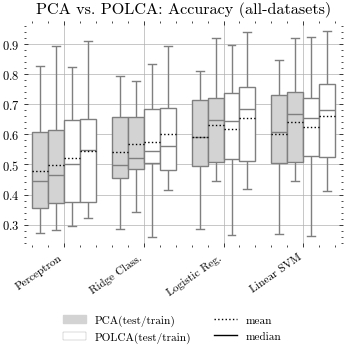

In [15]:
classifier_means = df_class_long.groupby("Classifier")["Value"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_long.sort_values(
    by=["Classifier", "Method"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="Value",
    hue="Method",
    fill=True,
    palette=["lightgray", "lightgray", "white", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)

plt.xlabel("")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend([])
tlabels = [t.get_text() for t in ax.get_xticklabels()]

tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("PCA vs. POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [16]:
# Reshape the DataFrame
df_metrics_long = (
    df_metrics.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_3": "Metric", "level_4": "Method", 0: "Value"})
)
df_metrics_long

,Dataset,N,Split,Metric,Method,Value
0,sinusoidal,8,test,NRMSE,PCA,0.1892
1,sinusoidal,8,test,NRMSE,POLCA,0.1189
2,sinusoidal,8,test,PSNR,PCA,20.4884
3,sinusoidal,8,test,PSNR,POLCA,24.6472
4,sinusoidal,8,test,SSIM,PCA,0.8325
...,...,...,...,...,...,...
187,tissue,8,train,NRMSE,POLCA,0.3848
188,tissue,8,train,PSNR,PCA,26.9254
189,tissue,8,train,PSNR,POLCA,27.0320
190,tissue,8,train,SSIM,PCA,0.6539


# Resconstruction Box Plot

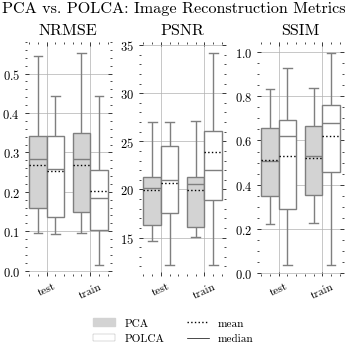

In [17]:
df = df_metrics_long
fig, axs = plt.subplots(1, 3, figsize=(3.5, 3.5))

for ax, metric, title in zip(axs, ["NRMSE", "PSNR", "SSIM"], ["NRMSE", "PSNR", "SSIM"]):
    ax = sns.boxplot(
        data=df[df["Metric"] == metric],
        x="Split",
        y="Value",
        hue="Method",
        fill=True,
        palette={"PCA": "lightgray","PCA-labels": "lightgray", "POLCA": "white", "POLCA-labels": "white"},
        gap=0.0,
        showmeans=True,
        meanprops={"ls": ":", "c": "k"},
        meanline=True,
        showfliers=False,
        fliersize=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize="small")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["test", "train"], rotation=25, ha="center", fontsize="xx-small")
    ax.grid()


plt.suptitle("PCA vs. POLCA: Image Reconstruction Metrics", fontsize="small")

PCA_patch = mpatches.Patch(color="lightgray", label="PCA")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median", lw=0.5)

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)
# Tweak the visual presentation
sns.despine(trim=True, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/image_metrics_comparison_boxplot.pdf", dpi=300, bbox_inches="tight")

# Loss Interaction Box Plot

In [19]:
df_loss = read_loss_interaction_csv_files(f"output/{experiment}/*/loss_interaction_report.csv")

# Step 1: Find the most common relationship for each unique losses value
most_common_relationship = (
    df_loss.groupby("losses")["relationship"].agg(lambda x: x.value_counts().index[0]).reset_index()
)

# Step 2: Create a dictionary for mapping
relationship_mapping = most_common_relationship.set_index("losses")["relationship"].to_dict()

# Step 3: Replace the values in the 'relationship' column
df_loss["common_relationship"] = df_loss["losses"].map(relationship_mapping)

# Step 4: Define the order of relationships from worst to best
relationship_order = [
    "Strongly Conflicting",
    "Conflicting",
    "Weakly Conflicting",
    "Weakly Cooperative",
    "Cooperative",
    "Strongly Cooperative",
]

# Step 5: Create a categorical column with the defined order
df_loss["relationship_category"] = pd.Categorical(
    df_loss["common_relationship"], categories=relationship_order, ordered=True
)


# Step 7: Drop the helper column used for sorting
df_loss = df_loss.drop(columns=["relationship_category"])



df_loss.head(10)

,Unnamed: 0,interactions,conflicts,conflict_rate,avg_similarity,relationship,Dataset,losses,common_relationship
0,0,2936,940,0.320163,-0.027427,Weakly Conflicting,organc,$\frac{rec}{com}$,Weakly Conflicting
1,1,2936,1044,0.355586,0.027902,Weakly Cooperative,organc,$\frac{rec}{ort}$,Weakly Cooperative
2,2,2936,38,0.012943,0.166608,Strongly Cooperative,organc,$\frac{ort}{com}$,Strongly Cooperative
0,0,2982,942,0.315895,-0.008672,Weakly Conflicting,chest,$\frac{rec}{com}$,Weakly Conflicting
1,1,2982,973,0.326291,0.063678,Weakly Cooperative,chest,$\frac{rec}{ort}$,Weakly Cooperative
2,2,2982,86,0.028840,0.095291,Weakly Cooperative,chest,$\frac{ort}{com}$,Strongly Cooperative
0,0,2932,936,0.319236,-0.028184,Weakly Conflicting,organs,$\frac{rec}{com}$,Weakly Conflicting
1,1,2932,914,0.311733,0.064509,Weakly Cooperative,organs,$\frac{rec}{ort}$,Weakly Cooperative
2,2,2932,55,0.018759,0.144475,Strongly Cooperative,organs,$\frac{ort}{com}$,Strongly Cooperative
0,0,2716,1128,0.415317,-0.062569,Weakly Conflicting,sinusoidal,$\frac{rec}{com}$,Weakly Conflicting


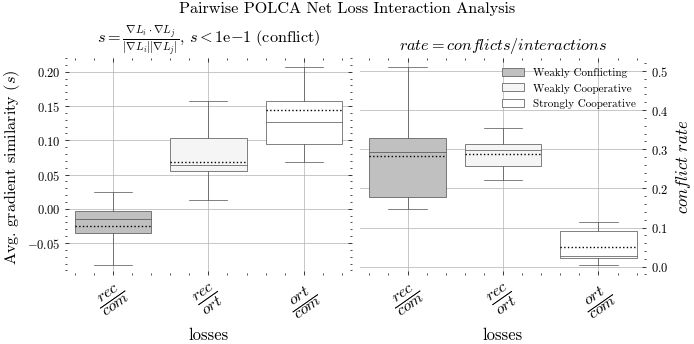

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
palette = {
    "Strongly Conflicting": "gray",
    "Weakly Conflicting": "silver",
    "Weakly Cooperative": "whitesmoke",
    "Strongly Cooperative": "white",
}

ax1 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="avg_similarity",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax1,
    saturation=0.6,
)
ax1.grid()
ax1.set_ylabel("Avg. gradient similarity ($s$)", fontsize="small")
similarity_form = r"$s=\frac{\nabla L_i \cdot \nabla L_j}{|\nabla L_i| |\nabla L_j|}$"
similarity_form += r", $s<1\mathrm{e}{-1}~(\text{conflict})$"
ax1.set_title(similarity_form,fontsize="small")
ax1.set_xticks(range(len(df_loss["losses"].unique())))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=35, ha="center", fontsize="large")
ax1.legend([])

ax2 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="conflict_rate",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax2,
    saturation=0.6,
)
ax2.grid()
ax2.set_ylabel("$conflict$ $rate$")
ax2.set_title("$rate = conflicts / interactions$",fontsize="small")
ax2.set_xticks(range(len(df_loss["losses"].unique())))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35, ha="center", fontsize="large")
# Move the y-axis to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend()
plt.suptitle("Pairwise POLCA Net Loss Interaction Analysis", fontsize="small")
sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/pairwise_loss_conflicts_boxplot.pdf", dpi=300, bbox_inches="tight")